# Код

#### Логирование

In [ ]:
!pip install wandb -qU

In [ ]:
import wandb

wandb.login()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 58.1 MB/s eta 0:00:00


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## База

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms as T

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import clear_output
from tqdm import tqdm
from PIL import Image

import os
import shutil
from random import shuffle

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

sns.set_style('whitegrid')
plt.rcParams.update({'font.size': 15})

In [ ]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
device

'cuda'

## Аугментации

In [ ]:
for_resize = (32, 32)

In [ ]:
# перспективное преобразование, случайный перспективный сдвиг на 100*s%
s = torch.rand(1)
perspective_transform = [T.Resize(for_resize), T.RandomPerspective(distortion_scale=s), T.ToTensor()]

# поворот изображения на t градусов
t = torch.randint(0, 360, (1,)).item()
rotation_transform = [T.Resize(for_resize), T.RandomRotation(t), T.ToTensor()]

# изменение свойств цвета изображения
# яркость
br = torch.randint(0, 100, (1,)).item()
# контраст
con = torch.randint(0, 100, (1,)).item()
# насыщенность
sat = torch.randint(0, 100, (1,)).item()
# оттенок
hue = min(0.5, torch.rand(1).item())
color_transform = [T.Resize(for_resize), T.ColorJitter(brightness=br, contrast=con, saturation=sat, hue=hue), T.ToTensor()]

# базовое преобразование
base_transforms = [T.Resize(for_resize), T.ToTensor()]

## Создание dataset

### Распределение изображений по папкам

In [ ]:
!unzip '/content/drive/MyDrive/graphs.zip' -d '/content/drive/MyDrive/graphs'

In [ ]:
!mkdir '/content/drive/MyDrive/graphs_classes'
!mkdir '/content/drive/MyDrive/graphs_classes/train'
!mkdir '/content/drive/MyDrive/graphs_classes/test'

In [ ]:
path_train = '/content/drive/MyDrive/graphs_classes/train'
path_test = '/content/drive/MyDrive/graphs_classes/test'

labels = {
    'binom': 0,
    'geom': 1,
    'poisson': 2,
    'norm': 3,
    'pareto': 4,
    'vigner': 5
}

In [ ]:
images = []
for image in os.listdir('/content/drive/MyDrive/graphs'):
    print(image.split('_')[0])
    if image.split('_')[0] in labels:
        images.append(image)

shuffle(images)

In [ ]:
# 70% на обучение, 30% на тест
for i in range(1, len(images)):
    image = images[i]
    if i < len(images) * 0.7:
        os.replace(f'/content/drive/MyDrive/graphs/{image}', f'{path_train}/{image}')
        shutil.move(f'/content/drive/MyDrive/graphs/graphs/{image}', f'{path_train}/{image}')
    else:
        os.replace(f'/content/drive/MyDrive/graphs/{image}', f'{path_test}/{image}')
        shutil.move(f'/content/drive/MyDrive/graphs/graphs/{image}', f'{path_test}/{image}')

### Создание dataset

In [ ]:
class dataset_statistic(torch.utils.data.Dataset):
    def __init__(self, root_dir, transforms=None):
        self.root_dir = root_dir
        self.transforms = transforms
        self.files = os.listdir(self.root_dir)

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.files[index])
        image = Image.open(img_path)
        label = labels[img_path.split('/')[-1].split('_')[0]]

        if self.transforms:
            for t in self.transforms:
                image = t(image)
        return (image, torch.tensor(label))

In [ ]:
def show_image(data):
    img = data[0]
    label = data[1].item()

    print(label)
    plt.grid('off')
    plt.axis('off')
    plt.imshow(img.permute(1, 2, 0))

## dataloaders с различными преобразованиями

### Тестовые данные фиксированны

In [ ]:
val_data = dataset_statistic(path_test, transforms=base_transforms)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=32, shuffle=False)

### Baseline модель

In [ ]:
train_data = dataset_statistic(path_train, transforms=base_transforms)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=False)

### Перспективное преобразование

In [ ]:
train_perspective_data = dataset_statistic(path_train, transforms=perspective_transform)
train_perspective_loader = torch.utils.data.DataLoader(train_perspective_data, batch_size=32, shuffle=True)

5


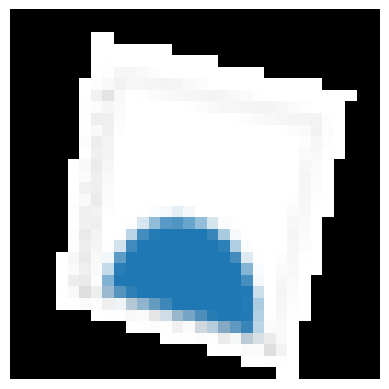

In [ ]:
data = train_perspective_data[19]
show_image(data)

### Поворот изображения

In [ ]:
train_rotate_data = dataset_statistic(path_train, transforms=rotation_transform)
train_rotate_loader = torch.utils.data.DataLoader(train_rotate_data, batch_size=32, shuffle=True)

5


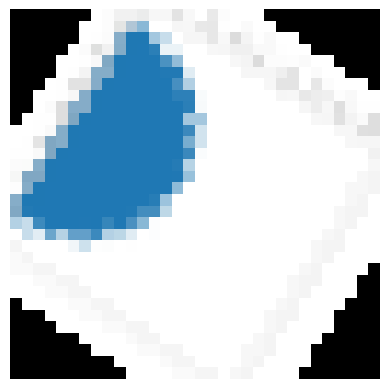

In [ ]:
data = train_rotate_data[19]
show_image(data)

### Изменение цвета изображения

In [ ]:
train_color_data = dataset_statistic(path_train, transforms=color_transform)
train_color_loader = torch.utils.data.DataLoader(train_color_data, batch_size=32, shuffle=True)

5


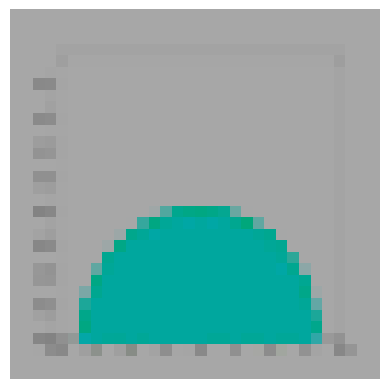

In [ ]:
data = train_color_data[19]
show_image(data)

## VGG-11

In [ ]:
class MOLI_Net(nn.Module):
    def __init__(self, img_channels=3, num_classes=6):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=img_channels, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        self.head = nn.Sequential(
            nn.Linear(in_features=512, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),

            nn.Linear(in_features=4096, out_features=num_classes)
        )

    def forward(self, x):
        out = self.encoder(x)
        out = nn.Flatten()(out)
        out = self.head(out)

        return out

## Визуализация

In [ ]:
def plot_logs(train_accuracy, val_accuracy, train_losses, val_losses):
  clear_output()
  fig, axs = plt.subplots(1, 2, figsize=(13, 4))

  axs[1].plot(train_accuracy, label='train')
  points = np.array(val_accuracy)
  axs[1].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
  axs[1].set_ylabel('accuracy')

  axs[0].plot(train_losses, label='train')
  points = np.array(val_losses)
  axs[0].scatter(points[:, 0], points[:, 1], marker='+', s=180, c='orange', label='val', zorder=2)
  axs[0].set_ylabel('loss')

  for ax in axs:
      ax.set_xlabel('step')
      ax.legend()

  plt.show()

## Обучение и тест

Нейросети обучают эпохами, эпоха -- это один цикл обучения модели на массиве данных

### Эпоха обучения

In [ ]:
def train_epoch(model, criterion, train_loader, optimizer, name):
    model.train()

    accuracy_log, loss_log = [], []
    accuracy_log_wb, loss_log_wb = 0, 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        logits = model(images)
        loss = criterion(logits, labels)

        loss.backward()
        optimizer.step()

        labels_pred = torch.max(logits, dim=1)[1].cpu().detach().numpy()
        labels_true = labels.cpu().detach().numpy()

        accuracy_log.append(np.mean(labels_pred == labels_true))
        loss_log.append(loss.item())

        accuracy_log_wb += (logits.argmax(dim=1) == labels).sum().item()
        loss_log_wb += loss.item() * images.shape[0]

        metrics = {
            f"{name} batch-train loss": loss.item()
        }
        wandb.log(metrics)

    accuracy_log_wb /= len(train_loader.dataset)
    loss_log_wb /= len(train_loader.dataset)

    return accuracy_log, loss_log, accuracy_log_wb, loss_log_wb

### Валидация

In [ ]:
def test(model, criterion, val_loader):
    model.eval()

    accuracy_log, loss_log = [], []
    accuracy_log_wb, loss_log_wb = 0, 0

    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(images)
            loss = criterion(logits, labels)

        labels_pred = torch.max(logits, dim=1)[1].cpu().detach().numpy()
        labels_true = labels.cpu().detach().numpy()

        accuracy_log.append(np.mean(labels_pred == labels_true))
        loss_log.append(loss.item())

        loss_log_wb += loss.item() * images.shape[0]
        accuracy_log_wb += (logits.argmax(dim=1) == labels).sum().item()

    accuracy_log_wb /= len(val_loader.dataset)
    loss_log_wb /= len(val_loader.dataset)

    return accuracy_log, loss_log, accuracy_log_wb, loss_log_wb,

### Полный цикл обучения

In [ ]:
def train(model, criterion, train_loader, val_loader, optimizer, num_epoches, batch_size, name, project_name):

    train_accuracy_log, train_loss_log = [], []
    val_accuracy_log, val_loss_log = [], []

    for epoch in range(1, num_epoches + 1):
        train_accuracy, train_loss, train_accuracy_wb, train_loss_wb = train_epoch(model, criterion, train_loader, optimizer, name)
        val_accuracy, val_loss, val_accuracy_wb, val_loss_wb = test(model, criterion, val_loader)

        train_accuracy_log.extend(train_accuracy)
        train_loss_log.extend(train_loss)

        steps = train_loader.dataset.__len__() / batch_size

        val_accuracy_log.append((steps * epoch, np.mean(val_accuracy)))
        val_loss_log.append((steps * epoch, np.mean(val_loss)))

        clear_output()
        plot_logs(train_accuracy_log, val_accuracy_log, train_loss_log, val_loss_log)

    info = {
        'train_acc': np.mean(train_accuracy_log),
        'test_acc': val_accuracy_log[-1],
        'train_loss': np.mean(val_loss_log),
        'test_loss': val_loss_log[-1]
    }

    metrics = {
            "train accuracy": train_accuracy_wb / len(train_loader.dataset),
            "train loss": train_loss_wb / len(train_loader.dataset),
            "val accuracy": val_accuracy_wb,
            "val loss": val_loss_wb
    }
    wandb.log(metrics)

    return info

## Тестирование модели

### базовые параметры

In [ ]:
def wandb_init(name, num_epoches):

    run = wandb.init(
        project='coursework',
        name=name,
        config={
            'architecture': 'CNN',
            'dataset': 'statistic_graphs',
            'epochs': num_epoches,
            'criterion': 'CrossEntropyLoss',
            'optimizer': 'AdamW'
        }
    )

    return run

In [ ]:
num_epoches = 10
LR = 0.05
batch_size = 32
criterion = nn.CrossEntropyLoss()

### Обучение baseline модели

In [ ]:
baseline_run = wandb_init('baseline', num_epoches)
baseline_model = MOLI_Net().to(device)
baseline_optimizer = torch.optim.AdamW(baseline_model.parameters())

wandb: Currently logged in as: molivka (molivka-bmstu). Use `wandb login --relogin` to force relogin


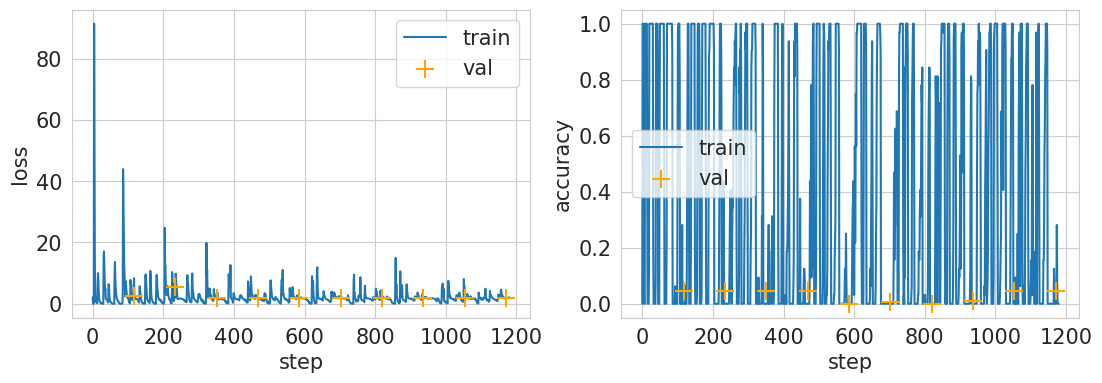

{'train_acc': 0.3668697033898305,
 'test_acc': (1170.3125, 0.045990566037735846),
 'train_loss': 322.9733536720838,
 'test_loss': (1170.3125, 1.8802263579278622)}

In [ ]:
train(baseline_model, criterion, train_loader, val_loader, baseline_optimizer, num_epoches, batch_size, 'baseline', 'MOLI_Net')

In [ ]:
torch.save(baseline_model.state_dict(), '/content/drive/MyDrive/baseline_model.h5')
artifact = wandb.Artifact(name='baseline_model', type='model')
artifact.add_file('/content/drive/MyDrive/baseline_model.h5')
baseline_run.log_artifact(artifact)

<Artifact baseline_model>

In [ ]:
baseline_run.finish()

baseline batch-train loss,▁▁▁▁▆▂▂▄▁█▂▂▄▂▁▂▇▃▃▃▄▃▃▂▁▂▁▁▁▃▁▃▄▄▄▂▂▁▂▃
train accuracy,▁
train loss,▁
val accuracy,▁
val loss,▁
baseline batch-train loss,2.11343
train accuracy,8e-05
train loss,0.00049
val accuracy,0.04676
val loss,1.88068


### Обучение perspective модели

In [ ]:
perspective_run = wandb_init('perspective', num_epoches)
perspective_model = MOLI_Net().to(device)
perspective_optimizer = torch.optim.AdamW(perspective_model.parameters())

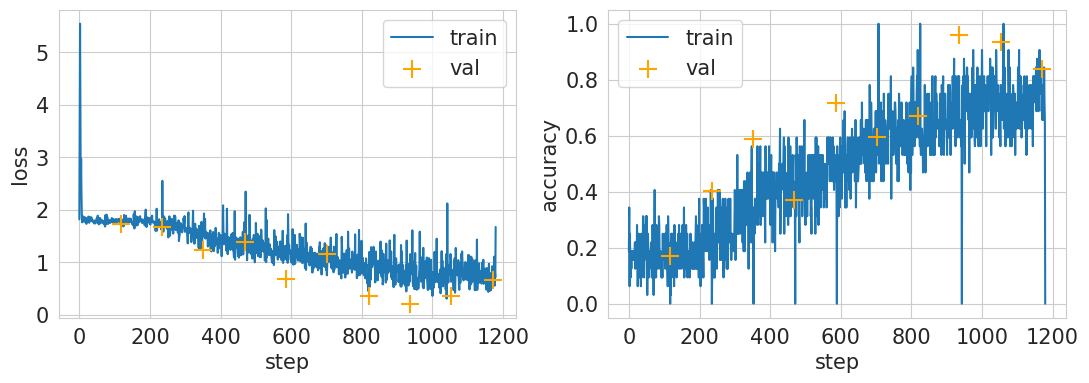

{'train_acc': 0.47698622881355934,
 'test_acc': (1170.3125, 0.8366745283018868),
 'train_loss': 322.3094282061897,
 'test_loss': (1170.3125, 0.6613226098447096)}

In [ ]:
train(perspective_model, criterion, train_perspective_loader, val_loader, perspective_optimizer, num_epoches, batch_size, 'perspective', 'MOLI_Net')

In [ ]:
torch.save(perspective_model.state_dict(), '/content/drive/MyDrive/perspective_model.h5')
artifact = wandb.Artifact(name='perspective_model', type='model')
artifact.add_file('/content/drive/MyDrive/perspective_model.h5')
perspective_run.log_artifact(artifact)

<Artifact perspective_model>

In [ ]:
perspective_run.finish()

perspective batch-train loss,▇▇▇▇▇▇▆▆▇▆▅▅▆█▄▅▅▄▄▃▃▃▃▄▃▃▆▂▆▄▂▂▃▃▂▃▃▂▄▁
train accuracy,▁
train loss,▁
val accuracy,▁
val loss,▁
perspective batch-train loss,1.67443
train accuracy,0.00019
train loss,0.00021
val accuracy,0.83393
val loss,0.66871


### Обучение rotate модели

In [ ]:
rotate_run = wandb_init('rotate', num_epoches)
rotate_model = MOLI_Net().to(device)
rotate_optimizer = torch.optim.AdamW(rotate_model.parameters())

wandb: Currently logged in as: molivka (molivka-bmstu). Use `wandb login --relogin` to force relogin


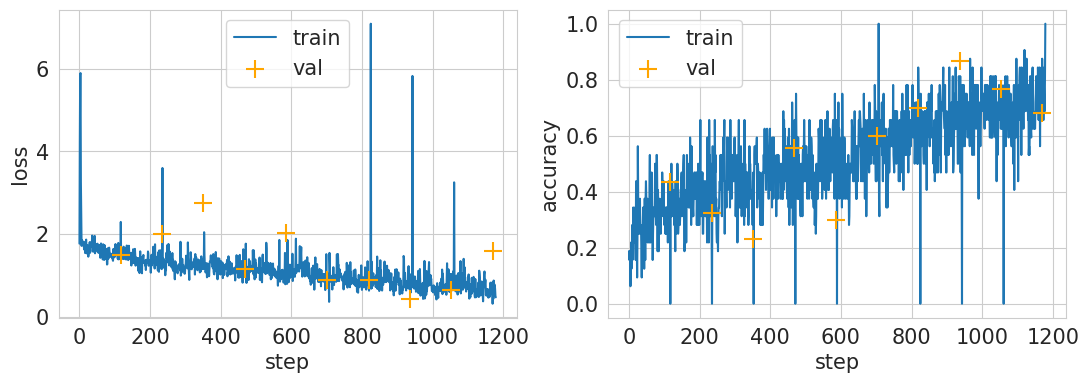

{'train_acc': 0.5227754237288136,
 'test_acc': (1170.3125, 0.6798349056603774),
 'train_loss': 322.5292708221217,
 'test_loss': (1170.3125, 1.578622691192717)}

In [ ]:
train(rotate_model, criterion, train_rotate_loader, val_loader, rotate_optimizer, num_epoches, batch_size, 'rotate', 'MOLI_Net')

In [ ]:
torch.save(rotate_model.state_dict(), '/content/drive/MyDrive/rotate_model.h5')
artifact = wandb.Artifact(name='rotate_model', type='model')
artifact.add_file('/content/drive/MyDrive/rotate_model.h5')
rotate_run.log_artifact(artifact)

<Artifact rotate_model>

In [ ]:
rotate_run.finish()

rotate batch-train loss,▃▂▂▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁█▂▁▁▁▁▁▂▁▁▂
train accuracy,▁
train loss,▁
val accuracy,▁
val loss,▁
rotate batch-train loss,0.47032
train accuracy,0.00019
train loss,0.00019
val accuracy,0.67446
val loss,1.59921


### Обучение color модели

In [ ]:
color_run = wandb_init('color', num_epoches)
color_model = MOLI_Net().to(device)
color_optimizer = torch.optim.AdamW(color_model.parameters())

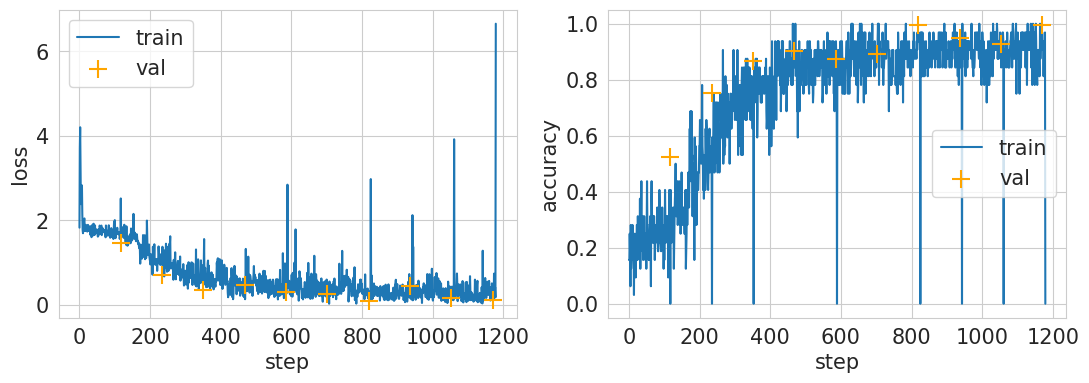

{'train_acc': 0.7431938559322034,
 'test_acc': (1170.3125, 0.9941037735849056),
 'train_loss': 322.05330785543055,
 'test_loss': (1170.3125, 0.12177086166532976)}

In [ ]:
train(color_model, criterion, train_color_loader, val_loader, color_optimizer, num_epoches, batch_size, 'color', 'MOLI_Net')

In [ ]:
torch.save(color_model.state_dict(), '/content/drive/MyDrive/color_model.h5')
artifact = wandb.Artifact(name='color_model', type='model')
artifact.add_file('/content/drive/MyDrive/color_model.h5')
color_run.log_artifact(artifact)

<Artifact color_model>

In [ ]:
color_run.finish()

color batch-train loss,███▇█▆▅▄▄▅▃▄▃▃▅▁▂▃▂▃▃▃▂▃▂▂▃▂▃▃▁▂▁▁▂▂▂▁▁▂
train accuracy,▁
train loss,▁
val accuracy,▁
val loss,▁
color batch-train loss,6.65304
train accuracy,0.00024
train loss,8e-05
val accuracy,0.994
val loss,0.11945
